In [82]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV

In [83]:
PRC_df = pd.read_csv('PRC_df.csv')

In [84]:
variables = ['EXRET', '12m_momentum', 'industry_momentum', '1m_reversal', 'MV', 'DV', 'BAS', 'annual_TRV', 'IV', 'MB', 'Book-to-Market', 'Earnings-Price', 'Sales-to-Price', 'tbl', 'T10Y3MM', 'gpce']

def descriptive_stats(group):
    desc = group[variables].describe().transpose()
    desc['variance'] = group[variables].var()
    return desc

grouped = PRC_df.groupby('TICKER').apply(descriptive_stats)
within_entity_stats = grouped.groupby(level=1).mean()
within_entity_stats = within_entity_stats[['mean', '50%', 'std', 'variance', 'min', 'max']]
within_entity_stats.columns = ['Mean', 'Median', 'Std Deviation', 'Variance', 'Min', 'Max']

print(within_entity_stats)

                           Mean        Median  Std Deviation      Variance  \
12m_momentum       1.779602e+12 -2.984515e+05   2.561804e+14  1.756681e+30   
1m_reversal        1.305102e+00  3.570763e-01   1.115530e+01  1.454386e+02   
BAS               -8.691994e-01 -3.564046e-01   1.349596e+00  5.010009e+00   
Book-to-Market     4.816647e+01  3.550345e+01   5.093758e+01  1.983651e+04   
DV                 8.861479e+09  4.470018e+09   1.259207e+10  2.522413e+20   
EXRET             -1.057364e+00 -2.002937e+00   1.121816e+01  1.468593e+02   
Earnings-Price     4.603797e+00  4.107512e+00   2.398232e+00  3.062016e+01   
IV                 2.408580e+00  2.408580e+00   6.438961e-15  8.532320e-29   
MB                 5.963139e-01  5.963139e-01   1.729207e-15  5.142309e-30   
MV                 7.310157e+10  5.974791e+10   5.916474e+10  1.407007e+22   
Sales-to-Price     6.739517e+00  5.975097e+00   3.564221e+00  2.936801e+02   
T10Y3MM            1.117485e+00  1.025492e+00   5.621107e-01  3.

In [85]:
def create_lag_features(df, features, lags):
    for feature in features:
        for lag in lags:
            df[f'{feature}_lag{lag}'] = df[feature].shift(lag)
    return df

features = ['12m_momentum', 'industry_momentum', '1m_reversal', 'MV', 'DV', 'BAS', 'annual_TRV', 'IV', 'MB', 'Earnings-Price', 'Sales-to-Price']
lags = [1, 3, 6, 12]
PRC_df = create_lag_features(PRC_df, features, lags)
PRC_df = PRC_df.dropna() 

In [86]:
PRC_df['date'] = pd.to_datetime(PRC_df['date'])
PRC_df = PRC_df.sort_values(by='date')

numeric_cols = PRC_df.select_dtypes(include=[np.number]).columns.tolist()
X = PRC_df[numeric_cols].drop(columns=['EXRET', 'PRC', 'SHROUT', 
                         'VOL', 'RET', 'year', '10Y'])

y = PRC_df['EXRET']

X.fillna(0, inplace=True)
y.fillna(0, inplace=True)

train_size = int(len(PRC_df) * 0.6)
val_size = int(len(PRC_df) * 0.2)
test_size = len(PRC_df) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Training Set Size: {train_size}")
print(f"Validation Set Size: {val_size}")
print(f"Test Set Size: {test_size}")

print(f"Training from {PRC_df['date'].iloc[0]} to {PRC_df['date'].iloc[train_size-1]}")
print(f"Validate from {PRC_df['date'].iloc[train_size]} to {PRC_df['date'].iloc[train_size+val_size-1]}")
print(f"Test from {PRC_df['date'].iloc[train_size+val_size]} to {PRC_df['date'].iloc[-1]}")

Training Set Size: 43192
Validation Set Size: 14397
Test Set Size: 14399
Training from 2004-01-01 00:00:00 to 2016-01-01 00:00:00
Validate from 2016-01-01 00:00:00 to 2020-01-01 00:00:00
Test from 2020-01-01 00:00:00 to 2023-12-01 00:00:00


In [87]:
def calculate_oos_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum(y_true ** 2)
    return 1 - (ss_res / ss_tot)

def calculate_sharpe_ratio(y_pred):
    return np.mean(y_pred) / np.std(y_pred)

# OLS

In [88]:
ols = LinearRegression()
ols.fit(X_train_scaled, y_train)
y_pred_val_ols = ols.predict(X_val_scaled)

mse_val_ols = mean_squared_error(y_val, y_pred_val_ols)
r2_val_ols = r2_score(y_val, y_pred_val_ols)
oos_r2_val_ols = calculate_oos_r2(y_val, y_pred_val_ols)
sharpe_ratio_val_ols = calculate_sharpe_ratio(y_pred_val_ols)

print(f"\nOLS (Validation) - MSE: {mse_val_ols}, R^2: {r2_val_ols}, Out-of-sample R^2: {oos_r2_val_ols}, Sharpe Ratio: {sharpe_ratio_val_ols}")


OLS (Validation) - MSE: 144.79579167932278, R^2: 0.004426092859772801, Out-of-sample R^2: 0.015426013172393116, Sharpe Ratio: -0.12945330806314065


In [89]:
y_pred_test_ols = ols.predict(X_test_scaled)

mse_test_ols = mean_squared_error(y_test, y_pred_test_ols)
r2_test_ols = r2_score(y_test, y_pred_test_ols)
oos_r2_test_ols = calculate_oos_r2(y_test, y_pred_test_ols)
sharpe_ratio_test_ols = calculate_sharpe_ratio(y_pred_test_ols)

print(f"\nOLS (Test) - MSE: {mse_test_ols}, R^2: {r2_test_ols}, Out-of-sample R^2: {oos_r2_test_ols}, Sharpe Ratio: {sharpe_ratio_test_ols}")


OLS (Test) - MSE: 173.49443322579558, R^2: 0.0991430188997231, Out-of-sample R^2: 0.10159566982281365, Sharpe Ratio: 0.33824833082422157


# Elastic Net

In [90]:
lasso = LassoCV(cv=5).fit(X_train_scaled, y_train)
selector = SelectFromModel(lasso, prefit=True)
X_train_selected = selector.transform(X_train_scaled)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

param_grid_en = {'alpha': [0.1, 1, 10], 'l1_ratio': [0.1, 0.5, 0.9]}
grid_search_en = GridSearchCV(ElasticNet(), param_grid_en, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error')
grid_search_en.fit(X_train_selected, y_train)

best_en = grid_search_en.best_estimator_
y_pred_val_en = best_en.predict(X_val_selected)

mse_val_en = mean_squared_error(y_val, y_pred_val_en)
r2_val_en = r2_score(y_val, y_pred_val_en)
oos_r2_val_en = calculate_oos_r2(y_val, y_pred_val_en)
sharpe_ratio_val_en = calculate_sharpe_ratio(y_pred_val_en)

print(f"\nElastic Net (Validation) - MSE: {mse_val_en}, R^2: {r2_val_en}, Out-of-sample R^2: {oos_r2_val_en}, Sharpe Ratio: {sharpe_ratio_val_en}")


Elastic Net (Validation) - MSE: 139.61605297222604, R^2: 0.04004047531372201, Out-of-sample R^2: 0.05064689860300031, Sharpe Ratio: -0.28860840164771373


In [91]:
y_pred_test_en = best_en.predict(X_test_selected)

print("\nElastic Net (Test) - Predictions:")
print(y_pred_test_en)

mse_test_en = mean_squared_error(y_test, y_pred_test_en)
r2_test_en = r2_score(y_test, y_pred_test_en)
oos_r2_test_en = calculate_oos_r2(y_test, y_pred_test_en)
sharpe_ratio_test_en = calculate_sharpe_ratio(y_pred_test_en)

print(f"\nElastic Net (Test) - MSE: {mse_test_en}, R^2: {r2_test_en}, Out-of-sample R^2: {oos_r2_test_en}, Sharpe Ratio: {sharpe_ratio_test_en}")


Elastic Net (Test) - Predictions:
[ 0.15077086  2.37743905  1.9649751  ... -2.3595977  -2.44705121
 -1.88697267]

Elastic Net (Test) - MSE: 176.2766965373571, R^2: 0.08469632294022011, Out-of-sample R^2: 0.08718830608021522, Sharpe Ratio: 0.18332119138518838


# PCA

In [14]:
lasso = LassoCV(cv=5).fit(X_train_scaled, y_train)
selector = SelectFromModel(lasso, prefit=True)
X_train_selected = selector.transform(X_train_scaled)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

n_components_range = [i for i in [5, 10, 15] if i <= min(X_train_selected.shape[0], X_train_selected.shape[1])]

pipeline_pcr = Pipeline([('pca', PCA()), ('linear_regression', LinearRegression())])
param_grid_pcr = {'pca__n_components' n_components_range}
grid_search_pcr = GridSearchCV(pipeline_pcr, param_grid_pcr, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error')
grid_search_pcr.fit(X_train_selected, y_train)

best_pcr = grid_search_pcr.best_estimator_
y_pred_val_pcr = best_pcr.predict(X_val_selected)

mse_val_pcr = mean_squared_error(y_val, y_pred_val_pcr)
r2_val_pcr = r2_score(y_val, y_pred_val_pcr)
oos_r2_val_pcr = calculate_oos_r2(y_val, y_pred_val_pcr)
sharpe_ratio_val_pcr = calculate_sharpe_ratio(y_pred_val_pcr)

print(f"\nPrincipal Component Regression (Validation) - MSE: {mse_val_pcr}, R^2: {r2_val_pcr}, Out-of-sample R^2: {oos_r2_val_pcr}, Sharpe Ratio: {sharpe_ratio_val_pcr}")


Principal Component Regression (Validation) - MSE: 161.9015219324432, R^2: -0.11319253047161615, Out-of-sample R^2: -0.10089492027853852, Sharpe Ratio: -0.49012200330750955


In [15]:
y_pred_test_pcr = best_pcr.predict(X_test_selected)

print("\nPrincipal Component Regression (Test) - Predictions:")
print(y_pred_test_pcr)

mse_test_pcr = mean_squared_error(y_test, y_pred_test_pcr)
r2_test_pcr = r2_score(y_test, y_pred_test_pcr)
oos_r2_test_pcr = calculate_oos_r2(y_test, y_pred_test_pcr)
sharpe_ratio_test_pcr = calculate_sharpe_ratio(y_pred_test_pcr)

print(f"\nPrincipal Component Regression (Test) - MSE: {mse_test_pcr}, R^2: {r2_test_pcr}, Out-of-sample R^2: {oos_r2_test_pcr}, Sharpe Ratio: {sharpe_ratio_test_pcr}")


Principal Component Regression (Test) - Predictions:
[ 0.79920179 -0.47493574 -0.2412106  ... -4.19512529 -4.77776483
 -3.41761081]

Principal Component Regression (Test) - MSE: 192.7144190640314, R^2: -0.0006516540592926834, Out-of-sample R^2: 0.0020734343992410142, Sharpe Ratio: -0.5711202599089401


# Random Forest

In [16]:
lasso = LassoCV(cv=5).fit(X_train_scaled, y_train)
selector = SelectFromModel(lasso, prefit=True)
X_train_selected = selector.transform(X_train_scaled)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

param_dist_rf = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2, 3]
}

random_search_rf = RandomizedSearchCV(RandomForestRegressor(), param_distributions=param_dist_rf, n_iter=10, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
random_search_rf.fit(X_train_selected, y_train)

best_rf = random_search_rf.best_estimator_
y_pred_val_rf = best_rf.predict(X_val_selected)

mse_val_rf = mean_squared_error(y_val, y_pred_val_rf)
r2_val_rf = r2_score(y_val, y_pred_val_rf)
oos_r2_val_rf = calculate_oos_r2(y_val, y_pred_val_rf)
sharpe_ratio_val_rf = calculate_sharpe_ratio(y_pred_val_rf)

print(f"\nRandom Forest (Validation) - MSE: {mse_val_rf}, R^2: {r2_val_rf}, Out-of-sample R^2: {oos_r2_val_rf}, Sharpe Ratio: {sharpe_ratio_val_rf}")


Random Forest (Validation) - MSE: 140.57987415050326, R^2: 0.0334095444496203, Out-of-sample R^2: 0.0440876188287862, Sharpe Ratio: -0.09698443702724185


In [17]:
y_pred_test_rf = best_rf.predict(X_test_selected)

print("\nRandom Forest (Test) - Predictions:")
print(y_pred_test_rf)

mse_test_rf = mean_squared_error(y_test, y_pred_test_rf)
r2_test_rf = r2_score(y_test, y_pred_test_rf)
oos_r2_test_rf = calculate_oos_r2(y_test, y_pred_test_rf)
sharpe_ratio_test_rf = calculate_sharpe_ratio(y_pred_test_rf)

print(f"\nRandom Forest (Test) - MSE: {mse_test_rf}, R^2: {r2_test_rf}, Out-of-sample R^2: {oos_r2_test_rf}, Sharpe Ratio: {sharpe_ratio_test_rf}")


Random Forest (Test) - Predictions:
[ 8.00534097  4.81191189  6.20737777 ... -3.03054356 -2.58653767
  0.78528155]

Random Forest (Test) - MSE: 225.7643992252448, R^2: -0.17226059476837685, Out-of-sample R^2: -0.16906816131339975, Sharpe Ratio: 0.73568049358219


# Gradient Boosting

In [18]:
lasso = LassoCV(cv=5).fit(X_train_scaled, y_train)
selector = SelectFromModel(lasso, prefit=True)
X_train_selected = selector.transform(X_train_scaled)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

param_dist_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

random_search_gb = RandomizedSearchCV(GradientBoostingRegressor(), param_distributions=param_dist_gb, n_iter=10, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
random_search_gb.fit(X_train_selected, y_train)

best_gb = random_search_gb.best_estimator_
y_pred_val_gb = best_gb.predict(X_val_selected)

mse_val_gb = mean_squared_error(y_val, y_pred_val_gb)
r2_val_gb = r2_score(y_val, y_pred_val_gb)
oos_r2_val_gb = calculate_oos_r2(y_val, y_pred_val_gb)
sharpe_ratio_val_gb = calculate_sharpe_ratio(y_pred_val_gb)

print(f"\nGradient Boosting (Validation) - MSE: {mse_val_gb}, R^2: {r2_val_gb}, Out-of-sample R^2: {oos_r2_val_gb}, Sharpe Ratio: {sharpe_ratio_val_gb}")

/Users/yuyangdou/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Gradient Boosting (Validation) - MSE: 138.10760060618483, R^2: 0.05040825088529077, Out-of-sample R^2: 0.06089853792326427, Sharpe Ratio: -0.4893597357962096


In [19]:
lasso = LassoCV(cv=5).fit(X_train_scaled, y_train)
selector = SelectFromModel(lasso, prefit=True)
X_train_selected = selector.transform(X_train_scaled)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

param_dist_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

random_search_gb = RandomizedSearchCV(GradientBoostingRegressor(), param_distributions=param_dist_gb, n_iter=8, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
random_search_gb.fit(X_train_selected, y_train)

best_gb = random_search_gb.best_estimator_
y_pred_val_gb = best_gb.predict(X_val_selected)

mse_val_gb = mean_squared_error(y_val, y_pred_val_gb)
r2_val_gb = r2_score(y_val, y_pred_val_gb)
oos_r2_val_gb = calculate_oos_r2(y_val, y_pred_val_gb)
sharpe_ratio_val_gb = calculate_sharpe_ratio(y_pred_val_gb)

print(f"\nGradient Boosting (Validation) - MSE: {mse_val_gb}, R^2: {r2_val_gb}, Out-of-sample R^2: {oos_r2_val_gb}, Sharpe Ratio: {sharpe_ratio_val_gb}")


Gradient Boosting (Validation) - MSE: 138.0924825515277, R^2: 0.050512198676013864, Out-of-sample R^2: 0.061001337386653365, Sharpe Ratio: -0.4876257427276455


In [20]:
y_pred_test_gb = best_gb.predict(X_test_selected)

print("\nGradient Boosting (Test) - Predictions:")
print(y_pred_test_gb)

mse_test_gb = mean_squared_error(y_test, y_pred_test_gb)
r2_test_gb = r2_score(y_test, y_pred_test_gb)
oos_r2_test_gb = calculate_oos_r2(y_test, y_pred_test_gb)
sharpe_ratio_test_gb = calculate_sharpe_ratio(y_pred_test_gb)

print(f"\nGradient Boosting (Test) - MSE: {mse_test_gb}, R^2: {r2_test_gb}, Out-of-sample R^2: {oos_r2_test_gb}, Sharpe Ratio: {sharpe_ratio_test_gb}")


Gradient Boosting (Test) - Predictions:
[ 0.20020051 -1.29540107 -0.49638489 ...  2.74903552  2.7010366
  3.58857953]

Gradient Boosting (Test) - MSE: 185.8701144668231, R^2: 0.034886759461319694, Out-of-sample R^2: 0.03751506566788099, Sharpe Ratio: 0.083210043769795


# Neural Network

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

lasso = LassoCV(cv=5).fit(X_train_scaled, y_train)
selector = SelectFromModel(lasso, prefit=True)
X_train_selected = selector.transform(X_train_scaled)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

param_dist_nn = {
    'hidden_layer_sizes': [(50,), (50, 50), (100,)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1]
}

random_search_nn = RandomizedSearchCV(MLPRegressor(max_iter=3000, early_stopping=True), param_distributions=param_dist_nn, n_iter=8, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
random_search_nn.fit(X_train_selected, y_train)

best_nn = random_search_nn.best_estimator_
y_pred_val_nn = best_nn.predict(X_val_selected)

mse_val_nn = mean_squared_error(y_val, y_pred_val_nn)
r2_val_nn = r2_score(y_val, y_pred_val_nn)
oos_r2_val_nn = calculate_oos_r2(y_val, y_pred_val_nn)
sharpe_ratio_val_nn = calculate_sharpe_ratio(y_pred_val_nn)

print(f"\nNeural Network (Validation) - MSE: {mse_val_nn}, R^2: {r2_val_nn}, Out-of-sample R^2: {oos_r2_val_nn}, Sharpe Ratio: {sharpe_ratio_val_nn}")


Neural Network (Validation) - MSE: 131.53474657585957, R^2: 0.09560147651470419, Out-of-sample R^2: 0.10559250699377598, Sharpe Ratio: -0.22220954358407222


In [22]:
y_pred_test_nn = best_nn.predict(X_test_selected)

print("\nNeural Network (Test) - Predictions:")
print(y_pred_test_nn)

mse_test_nn = mean_squared_error(y_test, y_pred_test_nn)
r2_test_nn = r2_score(y_test, y_pred_test_nn)
oos_r2_test_nn = calculate_oos_r2(y_test, y_pred_test_nn)
sharpe_ratio_test_nn = calculate_sharpe_ratio(y_pred_test_nn)

print(f"\nNeural Network (Test) - MSE: {mse_test_nn}, R^2: {r2_test_nn}, Out-of-sample R^2: {oos_r2_test_nn}, Sharpe Ratio: {sharpe_ratio_test_nn}")


Neural Network (Test) - Predictions:
[-3.15796956 -0.7206063  -5.32272289 ... -0.72046199 -7.36144733
 -6.01971481]

Neural Network (Test) - MSE: 180.9987023867841, R^2: 0.06018111252099301, Out-of-sample R^2: 0.06274053426680382, Sharpe Ratio: -0.0652073149836526


# SVM

In [23]:
lasso = LassoCV(cv=5).fit(X_train_scaled, y_train)
selector = SelectFromModel(lasso, prefit=True)
X_train_selected = selector.transform(X_train_scaled)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

param_dist_svm = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.5],
    'kernel': ['linear', 'rbf']
}

random_search_svm = RandomizedSearchCV(SVR(), param_distributions=param_dist_svm, n_iter=6, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error', n_jobs=1, random_state=42)
random_search_svm.fit(X_train_selected, y_train)

best_svm = random_search_svm.best_estimator_
y_pred_val_svm = best_svm.predict(X_val_selected)

mse_val_svm = mean_squared_error(y_val, y_pred_val_svm)
r2_val_svm = r2_score(y_val, y_pred_val_svm)
oos_r2_val_svm = calculate_oos_r2(y_val, y_pred_val_svm)
sharpe_ratio_val_svm = calculate_sharpe_ratio(y_pred_val_svm)

print(f"\nSVM (Validation) - MSE: {mse_val_svm}, R^2: {r2_val_svm}, Out-of-sample R^2: {oos_r2_val_svm}, Sharpe Ratio: {sharpe_ratio_val_svm}")


SVM (Validation) - MSE: 126.53902545244016, R^2: 0.1299507486681203, Out-of-sample R^2: 0.1395623174208548, Sharpe Ratio: -0.2780253191917096


In [24]:
y_pred_test_svm = best_svm.predict(X_test_selected)

print("\nSVM (Test) - Predictions:")
print(y_pred_test_svm)

mse_test_svm = mean_squared_error(y_test, y_pred_test_svm)
r2_test_svm = r2_score(y_test, y_pred_test_svm)
oos_r2_test_svm = calculate_oos_r2(y_test, y_pred_test_svm)
sharpe_ratio_test_svm = calculate_sharpe_ratio(y_pred_test_svm)

print(f"\nSVM (Test) - MSE: {mse_test_svm}, R^2: {r2_test_svm}, Out-of-sample R^2: {oos_r2_test_svm}, Sharpe Ratio: {sharpe_ratio_test_svm}")


SVM (Test) - Predictions:
[-1.67254284 -0.25285088 -3.16191037 ...  0.52809025 -1.89538658
 -4.36067733]

SVM (Test) - MSE: 171.07290625117398, R^2: 0.1117198835646559, Out-of-sample R^2: 0.11413894906404631, Sharpe Ratio: 0.04296549574780285


# KNN

In [25]:
lasso = LassoCV(cv=5).fit(X_train_scaled, y_train)
selector = SelectFromModel(lasso, prefit=True)
X_train_selected = selector.transform(X_train_scaled)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

param_grid_knn = {
    'n_neighbors': [5, 10, 20],
    'weights': ['uniform', 'distance']
}
grid_search_knn = GridSearchCV(KNeighborsRegressor(), param_grid_knn, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error')
grid_search_knn.fit(X_train_selected, y_train)

best_knn = grid_search_knn.best_estimator_
y_pred_val_knn = best_knn.predict(X_val_selected)

mse_val_knn = mean_squared_error(y_val, y_pred_val_knn)
r2_val_knn = r2_score(y_val, y_pred_val_knn)
oos_r2_val_knn = calculate_oos_r2(y_val, y_pred_val_knn)
sharpe_ratio_val_knn = calculate_sharpe_ratio(y_pred_val_knn)

print(f"\nKNN (Validation) - MSE: {mse_val_knn}, R^2: {r2_val_knn}, Out-of-sample R^2: {oos_r2_val_knn}, Sharpe Ratio: {sharpe_ratio_val_knn}")


KNN (Validation) - MSE: 149.12506468799648, R^2: -0.025344951272559868, Out-of-sample R^2: -0.014017806884654371, Sharpe Ratio: -0.5081122304039188


In [26]:
y_pred_test_knn = best_knn.predict(X_test_selected)

print("\nKNN (Test) - Predictions:")
print(y_pred_test_knn)

mse_test_knn = mean_squared_error(y_test, y_pred_test_knn)
r2_test_knn = r2_score(y_test, y_pred_test_knn)
oos_r2_test_knn = calculate_oos_r2(y_test, y_pred_test_knn)
sharpe_ratio_test_knn = calculate_sharpe_ratio(y_pred_test_knn)

print(f"\nKNN (Test) - MSE: {mse_test_knn}, R^2: {r2_test_knn}, Out-of-sample R^2: {oos_r2_test_knn}, Sharpe Ratio: {sharpe_ratio_test_knn}")


KNN (Test) - Predictions:
[-1.45042168 -0.18687718 -0.54647412 ... -7.0304791   0.42985455
 -4.64007024]

KNN (Test) - MSE: 187.1775771169183, R^2: 0.02809788154656545, Out-of-sample R^2: 0.030744675998038762, Sharpe Ratio: -0.21427808031737994


# XGB

In [61]:
lasso = LassoCV(cv=5).fit(X_train_scaled, y_train)
selector = SelectFromModel(lasso, prefit=True, max_features=20)  # 指定选择20个特征
X_train_selected = selector.transform(X_train_scaled)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = [X.columns[i] for i in selected_feature_indices]
print(f"Selected features: {selected_feature_names}")

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0]
}
grid_search_xgb = GridSearchCV(xgb.XGBRegressor(), param_grid_xgb, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_xgb.fit(X_train_selected, y_train)

best_xgb = grid_search_xgb.best_estimator_
y_pred_val_xgb = best_xgb.predict(X_val_selected)

mse_val_xgb = mean_squared_error(y_val, y_pred_val_xgb)
r2_val_xgb = r2_score(y_val, y_pred_val_xgb)
oos_r2_val_xgb = calculate_oos_r2(y_val, y_pred_val_xgb)
sharpe_ratio_val_xgb = calculate_sharpe_ratio(y_pred_val_xgb)

print(f"\nXGBoost (Validation) - MSE: {mse_val_xgb}, R^2: {r2_val_xgb}, Out-of-sample R^2: {oos_r2_val_xgb}, Sharpe Ratio: {sharpe_ratio_val_xgb}")

Selected features: ['tbl', 'T10Y3MM', 'gpce', '1m_reversal', 'DV', 'annual_TRV', 'Earnings-Price', 'Sales-to-Price', 'industry_momentum_lag3', '1m_reversal_lag1', '1m_reversal_lag3', '1m_reversal_lag6', '1m_reversal_lag12', 'MV_lag1', 'DV_lag1', 'DV_lag3', 'DV_lag6', 'DV_lag12', 'Earnings-Price_lag12']

XGBoost (Validation) - MSE: 118.98794062065228, R^2: 0.18187339858173013, Out-of-sample R^2: 0.19091273494510097, Sharpe Ratio: -0.23411300778388977


In [62]:
y_pred_test_xgb = best_xgb.predict(X_test_selected)

mse_test_xgb = mean_squared_error(y_test, y_pred_test_xgb)
r2_test_xgb = r2_score(y_test, y_pred_test_xgb)
oos_r2_test_xgb = calculate_oos_r2(y_test, y_pred_test_xgb)
sharpe_ratio_test_xgb = calculate_sharpe_ratio(y_pred_test_xgb)

print(f"\nXGBoost (Test) - MSE: {mse_test_xgb}, R^2: {r2_test_xgb}, Out-of-sample R^2: {oos_r2_test_xgb}, Sharpe Ratio: {sharpe_ratio_test_xgb}")


XGBoost (Test) - MSE: 161.9566158304291, R^2: 0.15905228027497942, Out-of-sample R^2: 0.16134182372563377, Sharpe Ratio: -0.04083969444036484


# XGB Analysis

## Volatility

In [63]:
volatility = np.std(y_pred_test_xgb)
print(f'Volatility: {volatility}')

Volatility: 6.359417915344238


## Cumulative Return

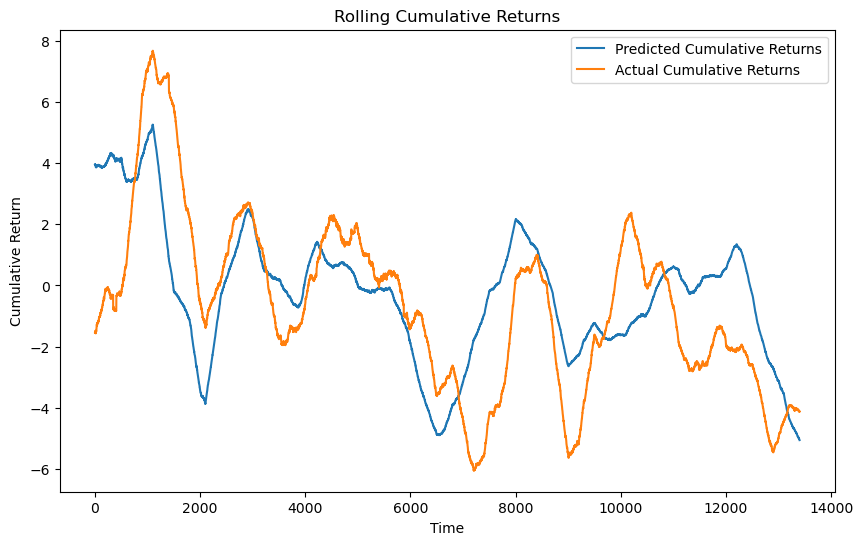

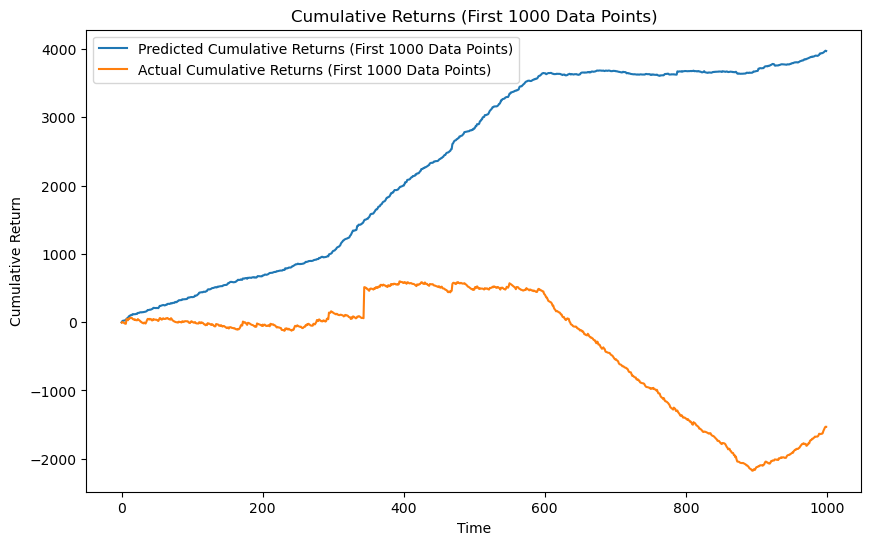

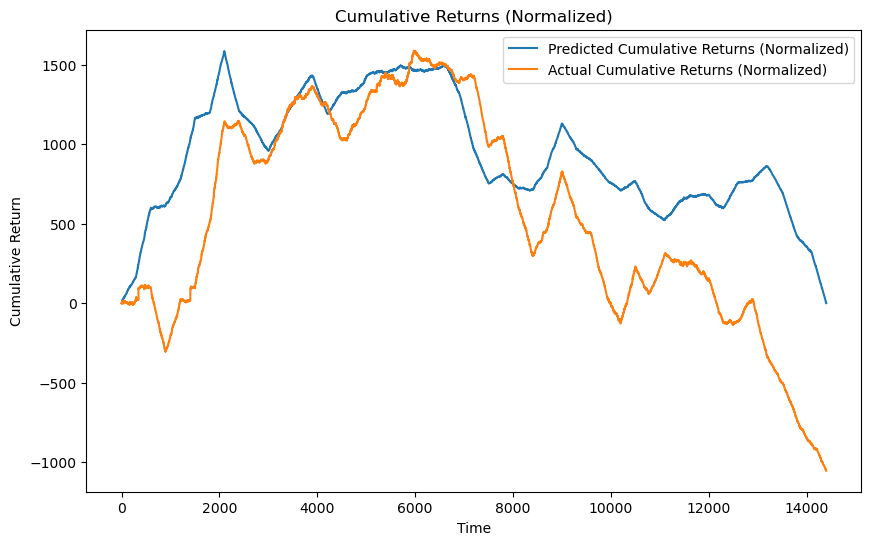

In [64]:
y_pred_test_xgb = np.array(y_pred_test_xgb) 
y_test = np.array(y_test) 

window_size = 1000  
rolling_returns_pred = np.convolve(y_pred_test_xgb, np.ones(window_size), 'valid') / window_size
rolling_returns_actual = np.convolve(y_test, np.ones(window_size), 'valid') / window_size

plt.figure(figsize=(10, 6))
plt.plot(rolling_returns_pred, label='Predicted Cumulative Returns')
plt.plot(rolling_returns_actual, label='Actual Cumulative Returns')
plt.legend()
plt.title('Rolling Cumulative Returns')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(y_pred_test_xgb[:1000]), label='Predicted Cumulative Returns (First 1000 Data Points)')
plt.plot(np.cumsum(y_test[:1000]), label='Actual Cumulative Returns (First 1000 Data Points)')
plt.legend()
plt.title('Cumulative Returns (First 1000 Data Points)')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.show()

scaler = StandardScaler()
y_pred_test_xgb_scaled = scaler.fit_transform(y_pred_test_xgb.reshape(-1, 1)).flatten()
y_test_scaled = scaler.transform(y_test.reshape(-1, 1)).flatten()

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(y_pred_test_xgb_scaled), label='Predicted Cumulative Returns (Normalized)')
plt.plot(np.cumsum(y_test_scaled), label='Actual Cumulative Returns (Normalized)')
plt.legend()
plt.title('Cumulative Returns (Normalized)')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.show()

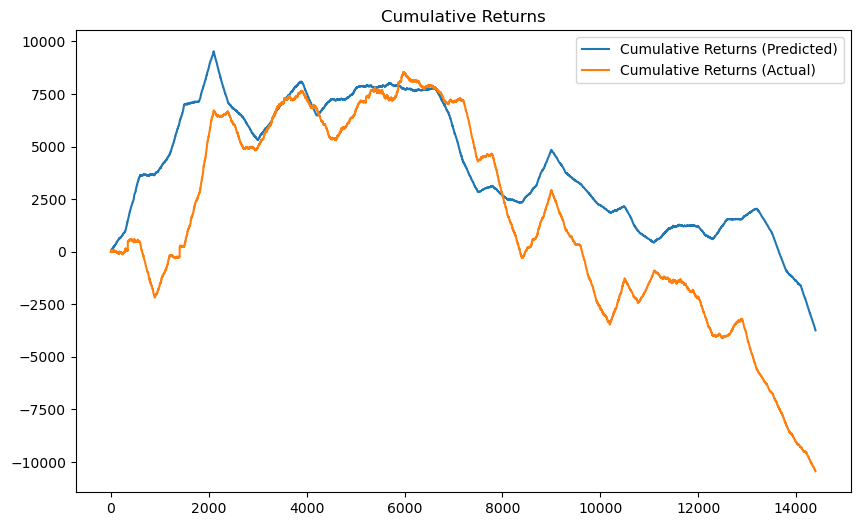

In [65]:
cumulative_returns = np.cumsum(y_pred_test_xgb)
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label='Cumulative Returns (Predicted)')
plt.plot(np.cumsum(y_test), label='Cumulative Returns (Actual)')
plt.legend()
plt.title('Cumulative Returns')
plt.show()

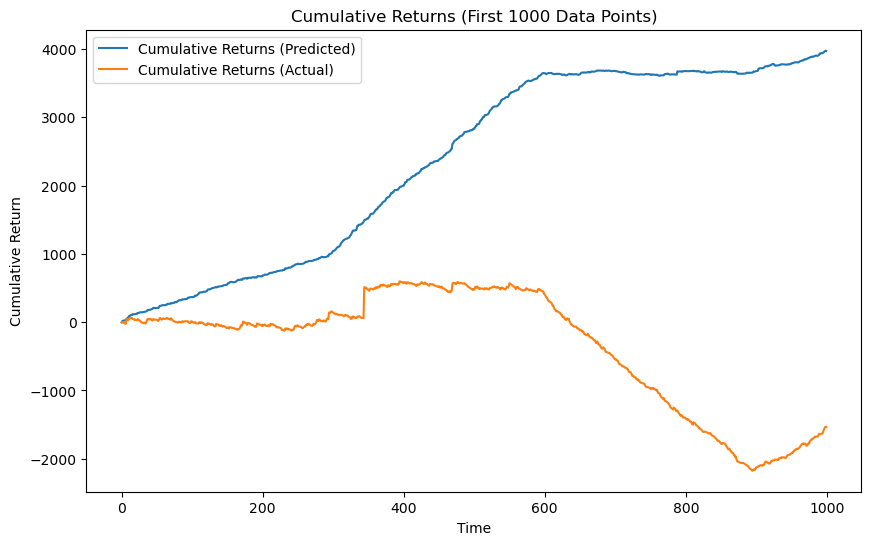

In [66]:
cumulative_returns_pred = np.cumsum(y_pred_test_xgb[:1000])
cumulative_returns_actual = np.cumsum(y_test[:1000])

plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns_pred, label='Cumulative Returns (Predicted)')
plt.plot(cumulative_returns_actual, label='Cumulative Returns (Actual)')
plt.legend()
plt.title('Cumulative Returns (First 1000 Data Points)')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.show()

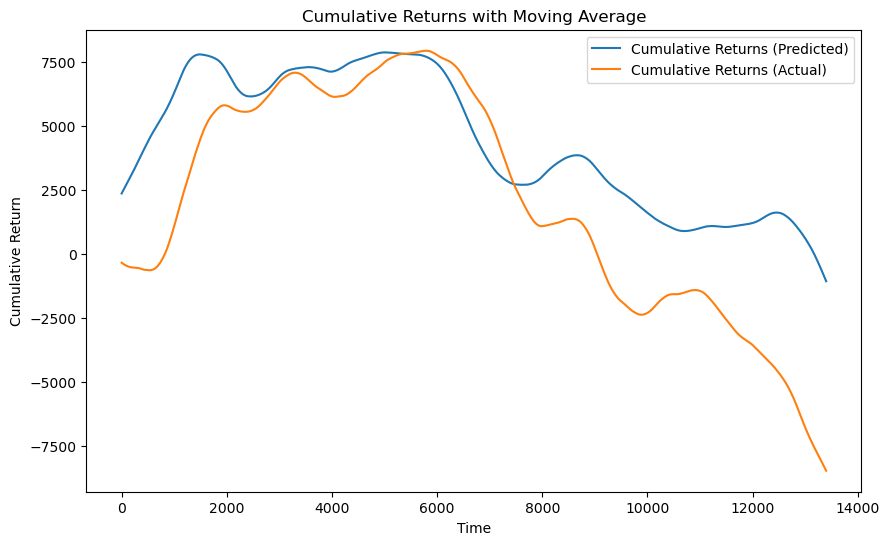

In [67]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

window_size = 1000
cumulative_returns_pred = moving_average(np.cumsum(y_pred_test_xgb), window_size)
cumulative_returns_actual = moving_average(np.cumsum(y_test), window_size)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns_pred, label='Cumulative Returns (Predicted)')
plt.plot(cumulative_returns_actual, label='Cumulative Returns (Actual)')
plt.legend()
plt.title('Cumulative Returns with Moving Average')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.show()


## Annual Return

In [68]:
num_periods = len(y_pred_test_xgb)
annualized_return_pred = (1 + np.mean(y_pred_test_xgb)) ** 12 - 1 
annualized_return_actual = (1 + np.mean(y_test)) ** 12 - 1

print(f'Predicted Annualized Return: {annualized_return_pred}')
print(f'Actual Annualized Return: {annualized_return_actual}')

Predicted Annualized Return: -0.9729120898270572
Actual Annualized Return: -0.9999998137347466


## Feature Importance

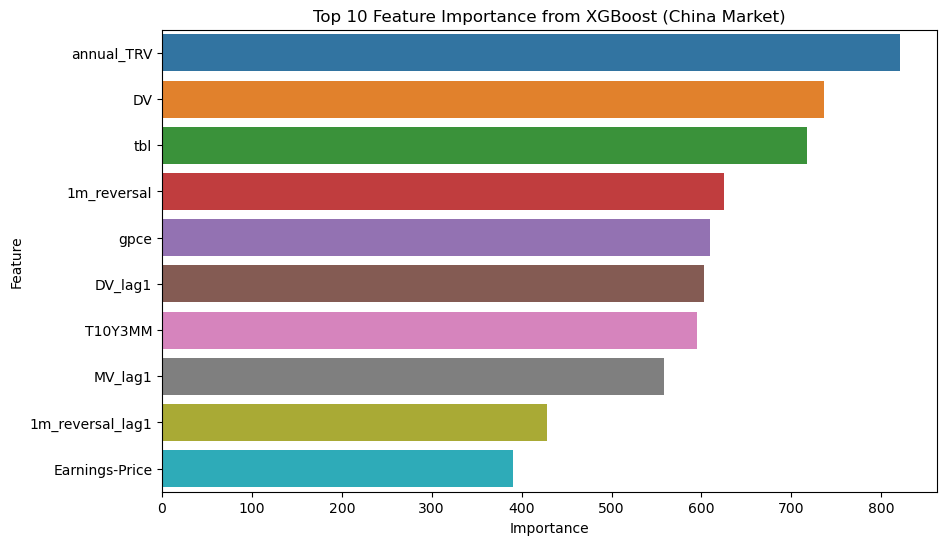

In [69]:
feature_importance = best_xgb.get_booster().get_score(importance_type='weight')
importance_df = pd.DataFrame({
    'Feature': [selected_feature_names[int(feat[1:])] for feat in feature_importance.keys()],
    'Importance': list(feature_importance.values())
})

importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Top 10 Feature Importance from XGBoost (China Market)')
plt.show()

## Industry Analysis

In [70]:
def calculate_oos_r2(y_true, y_pred):
    ss_res = sum((y_true - y_pred) ** 2)
    ss_tot = sum((y_true - y_true.mean()) ** 2)
    return 1 - ss_res / ss_tot

def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns)

PRC_df_clean = PRC_df.copy()
PRC_df_clean = PRC_df_clean.select_dtypes(include=[np.number])

industry_results = []
industries = PRC_df['CSRCIC-2'].unique()

for industry in industries:
    industry_data = PRC_df[PRC_df['CSRCIC-2'] == industry]  
    industry_data_clean = PRC_df_clean.loc[industry_data.index]  
    
    if len(industry_data) > 100:  
        X_industry = industry_data_clean.drop(columns=['EXRET'])
        y_industry = industry_data['EXRET']
        
       
        X_train, X_temp, y_train, y_temp = train_test_split(X_industry, y_industry, train_size=0.6, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5, random_state=42)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)

        
        lasso = LassoCV(cv=5, random_state=42).fit(X_train_scaled, y_train)
        selector = SelectFromModel(lasso, prefit=True, max_features=20)  # 指定选择20个特征
        X_train_selected = selector.transform(X_train_scaled)
        X_val_selected = selector.transform(X_val_scaled)
        X_test_selected = selector.transform(X_test_scaled)

        
        param_grid_xgb = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0]
        }
        grid_search_xgb = GridSearchCV(xgb.XGBRegressor(random_state=42), param_grid_xgb, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search_xgb.fit(X_train_selected, y_train)

        best_xgb = grid_search_xgb.best_estimator_
        
        y_train_pred = best_xgb.predict(X_train_selected)
        y_val_pred = best_xgb.predict(X_val_selected)
        y_test_pred = best_xgb.predict(X_test_selected)
        
        mse_val = mean_squared_error(y_val, y_val_pred)
        r2_val = r2_score(y_val, y_val_pred)
        oos_r2_val = calculate_oos_r2(y_val, y_val_pred)
        sharpe_ratio_val = calculate_sharpe_ratio(y_val_pred)

        mse_test = mean_squared_error(y_test, y_test_pred)
        r2_test = r2_score(y_test, y_test_pred)
        oos_r2_test = calculate_oos_r2(y_test, y_test_pred)
        sharpe_ratio_test = calculate_sharpe_ratio(y_test_pred)
        
        industry_results.append({
            'Industry': industry,
            'Validation MSE': mse_val,
            'Validation R2': r2_val,
            'Out-of-sample Validation R2': oos_r2_val,
            'Validation Sharpe Ratio': sharpe_ratio_val,
            'Test MSE': mse_test,
            'Test R2': r2_test,
            'Out-of-sample Test R2': oos_r2_test,
            'Test Sharpe Ratio': sharpe_ratio_test
        })

industry_results_df = pd.DataFrame(industry_results)
industry_results_df = industry_results_df.sort_values(by='Out-of-sample Test R2', ascending=False)

print(industry_results_df.head(5))

   Industry  Validation MSE  Validation R2  Out-of-sample Validation R2  \
38      C31        0.154466       0.998841                     0.998841   
34      B07        0.150970       0.995774                     0.995774   
18      C15        0.894869       0.994138                     0.994138   
14      C37        9.414486       0.959801                     0.959801   
15      I65        0.120349       0.998557                     0.998557   

    Validation Sharpe Ratio  Test MSE   Test R2  Out-of-sample Test R2  \
38                -0.150046  0.182444  0.998416               0.998416   
34                -0.296232  0.103510  0.997561               0.997561   
18                -0.071231  0.373223  0.997257               0.997257   
14                -0.012443  0.465414  0.997170               0.997170   
15                -0.092735  0.299390  0.997059               0.997059   

    Test Sharpe Ratio  
38          -0.152664  
34          -0.319316  
18           0.008322  
14      

In [71]:
top5_industries_by_out_of_sample_test_r2 = industry_results_df.sort_values(by='Out-of-sample Test R2', ascending=False).head(5)
print(top5_industries_by_out_of_sample_test_r2)

   Industry  Validation MSE  Validation R2  Out-of-sample Validation R2  \
38      C31        0.154466       0.998841                     0.998841   
34      B07        0.150970       0.995774                     0.995774   
18      C15        0.894869       0.994138                     0.994138   
14      C37        9.414486       0.959801                     0.959801   
15      I65        0.120349       0.998557                     0.998557   

    Validation Sharpe Ratio  Test MSE   Test R2  Out-of-sample Test R2  \
38                -0.150046  0.182444  0.998416               0.998416   
34                -0.296232  0.103510  0.997561               0.997561   
18                -0.071231  0.373223  0.997257               0.997257   
14                -0.012443  0.465414  0.997170               0.997170   
15                -0.092735  0.299390  0.997059               0.997059   

    Test Sharpe Ratio  
38          -0.152664  
34          -0.319316  
18           0.008322  
14      